# Finance clustering 

## Yahoo Finance

In [1]:
import sys
sys.path.append(
    "/Users/dmitrys/Desktop/DataProjects/otus-public/OpenLessons/ts-clustering/"
)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import yfinance as yf

In [2]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [3]:
msft = yf.Ticker("MSFT")
msft.history()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-26,213.291593,215.775081,207.556608,209.531433,37111600,0.00,0
2020-10-27,211.037492,214.109451,209.780788,212.693161,36700300,0.00,0
2020-10-28,207.127732,208.294676,201.572285,202.150757,51195600,0.00,0
2020-10-29,203.537128,206.818530,202.838944,204.185425,31432600,0.00,0
2020-10-30,202.968624,203.756554,199.098750,201.941315,36953700,0.00,0
2020-11-02,203.756540,204.743960,199.597430,201.801666,30842200,0.00,0
2020-11-03,203.357600,207.576550,202.589606,205.890961,27512000,0.00,0
2020-11-04,213.461145,217.749919,211.865317,215.824951,42311800,0.00,0
2020-11-05,221.460204,223.534774,220.572528,222.706940,36080100,0.00,0


## In case you need all tickers

In [4]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv', 
    header=None,
    error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4])

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


## Loading interesting tickers

In [5]:
get_info(msft)

{'shortName': 'Microsoft Corporation',
 'sector': 'Technology',
 'industry': 'Software—Infrastructure',
 'country': 'United States',
 'market': 'us_market'}

In [6]:
trending = pd.read_html("https://finance.yahoo.com/trending-tickers")[0]
most_active = pd.read_html("https://finance.yahoo.com/most-active")[0]
gainers = pd.read_html("https://finance.yahoo.com/gainers")[0]
losers = pd.read_html("https://finance.yahoo.com/losers")[0]

In [7]:
interesting_tickers = set()

for df in [trending, most_active, gainers, losers]:
    interesting_tickers = interesting_tickers.union(set(df['Symbol']))
    
interesting_tickers = list(interesting_tickers)
interesting_tickers[:4]

['SWIR', 'WEI', 'BKRKF', 'FROG']

In [8]:
len(interesting_tickers)

83

In [9]:
full_ticker_data = []

for ticker in tqdm(interesting_tickers):
    try:
        ticker_obj = yf.Ticker(ticker)
        close_price = ticker_obj.history(period='3mo')['Close'].to_dict()
        info = get_info(ticker_obj)
        info.update(close_price)
        full_ticker_data.append(info)
    except:
        continue
        
full_ticker_df = pd.DataFrame(full_ticker_data)

In [10]:
full_ticker_df = full_ticker_df.dropna()

In [11]:
full_ticker_df

,shortName,sector,industry,country,market,2020-08-25 00:00:00,2020-08-26 00:00:00,2020-08-27 00:00:00,2020-08-28 00:00:00,2020-08-31 00:00:00,...,2020-11-12 00:00:00,2020-11-13 00:00:00,2020-11-16 00:00:00,2020-11-17 00:00:00,2020-11-18 00:00:00,2020-11-19 00:00:00,2020-11-20 00:00:00,2020-11-23 00:00:00,2020-11-24 00:00:00,2020-11-25 00:00:00
0,"Sierra Wireless, Inc.",Technology,Communication Equipment,Canada,us_market,12.68000,12.630000,12.320000,12.560000,12.400000,...,10.800000,11.300000,10.960000,10.770000,11.030000,11.170000,11.380000,11.220000,11.210000,14.570000
1,Weidai Ltd.,Financial Services,Credit Services,China,us_market,1.30000,1.230000,1.200000,1.280000,1.280000,...,1.520000,1.460000,1.450000,1.490000,1.690000,1.610000,1.600000,1.660000,1.740000,2.025000
2,BANK RAKYAT INDONESIA,Financial Services,Banks—Regional,Indonesia,us_market,0.25000,0.250000,0.250000,0.250000,0.250000,...,0.300000,0.260000,0.260000,0.300000,0.270000,0.270000,0.270000,0.270000,0.270000,0.290000
4,Yunji Inc. - American Depositor,Consumer Cyclical,Internet Retail,China,us_market,2.62000,2.580000,2.510000,2.570000,2.510000,...,1.970000,1.870000,1.900000,1.850000,1.860000,1.850000,1.890000,2.250000,4.290000,4.588900
5,"Amazon.com, Inc.",Consumer Cyclical,Internet Retail,United States,us_market,3346.48999,3441.850098,3400.000000,3401.800049,3450.959961,...,3110.280029,3128.810059,3131.060059,3135.659912,3105.459961,3117.020020,3099.399902,3098.389893,3118.060059,3186.010010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,TELESITES SAB DE CV,Communication Services,Telecom Services,Mexico,us_market,0.75000,0.725000,0.750000,0.765000,0.735000,...,0.960000,0.990500,0.970000,0.981000,0.960000,1.060000,1.020000,0.980000,0.960000,1.040000
78,XIAOMI CORPORATION,Technology,Consumer Electronics,China,us_market,11.76000,13.060000,14.100000,14.940000,15.650000,...,14.970000,15.560000,16.230000,15.720000,15.450000,16.200001,16.660000,18.650000,18.000000,17.030001
79,Canada Goose Holdings Inc. Subo,Consumer Cyclical,Apparel Manufacturing,Canada,us_market,23.92000,24.100000,24.309999,25.150000,24.490000,...,33.950001,33.900002,33.820000,34.419998,35.650002,35.680000,34.770000,35.720001,38.650002,35.759998
80,"MMTec, Inc.",Technology,Software—Application,China,us_market,1.00500,1.010000,0.965000,0.980000,0.930000,...,1.040000,1.030000,1.020000,1.090000,1.075000,1.060000,1.050000,1.081000,1.200000,2.170000


## Scaling everything

In [12]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:].T).T

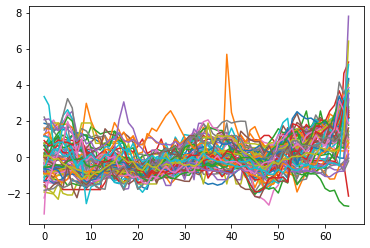

In [13]:
plt.plot(tickers_scaled.T);

# Basic KMeans

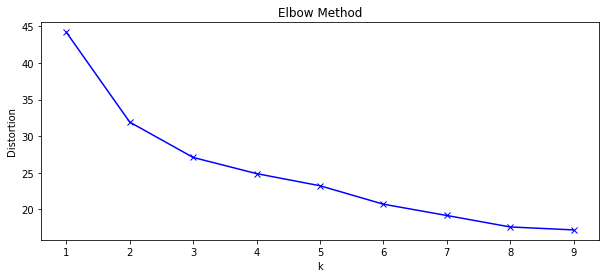

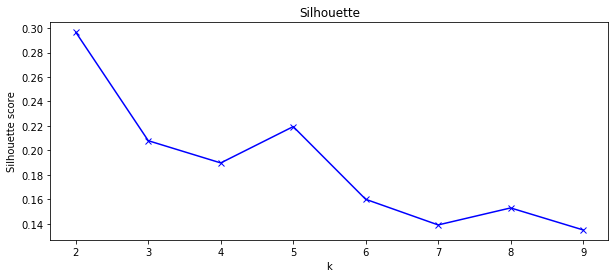

In [14]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [25]:
n_clusters = 5
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=3, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_clusters=5, n_jobs=3)

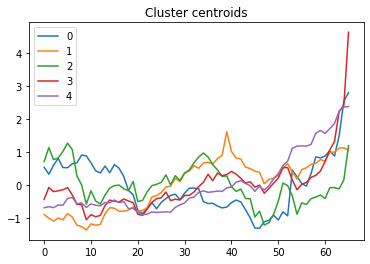

In [26]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [27]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Consumer Cyclical            6
        Financial Services           2
        Consumer Defensive           1
        Energy                       1
        Industrials                  1
        Real Estate                  1
1       Communication Services       2
        Consumer Cyclical            2
        Financial Services           2
        Technology                   2
        Basic Materials              1
        Consumer Defensive           1
        Industrials                  1
2       Technology                   6
        Healthcare                   3
        Consumer Cyclical            2
        Basic Materials              1
        Communication Services       1
        Industrials                  1
3       Consumer Cyclical            3
        Technology                   2
        Communication Services       1
        Financial Services           1
        Industrials                  1
4       Healthcare                   6
        Consumer Cyclical            5
        Basic Materials              4
        Financial Services           4
        Technology                   3
        Industrials                  2
        Consumer Defensive           1

In [28]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


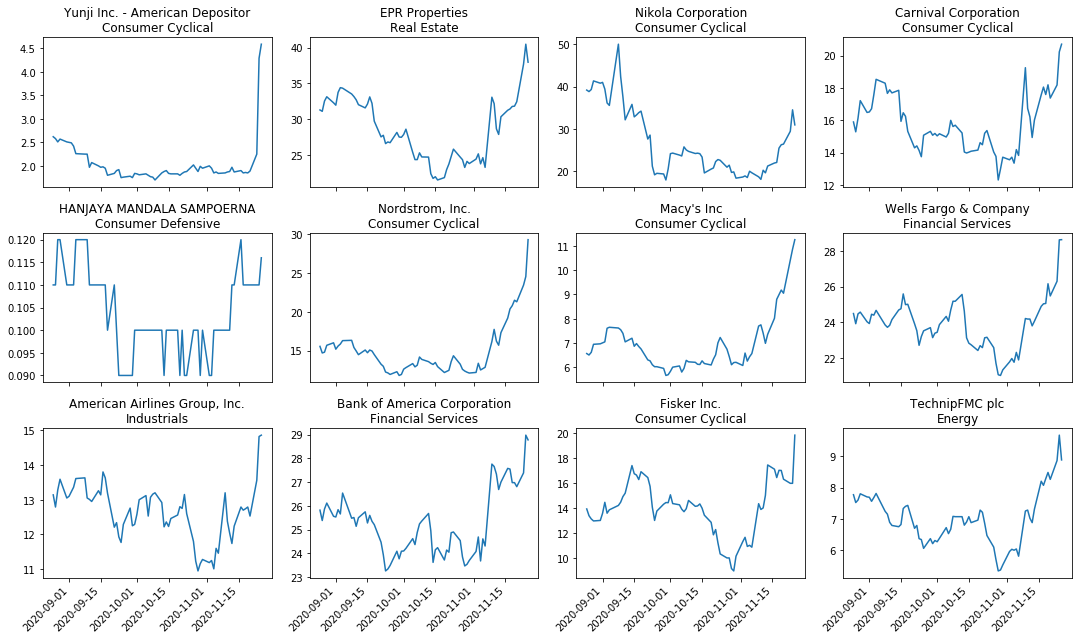

                          Cluster number: 1


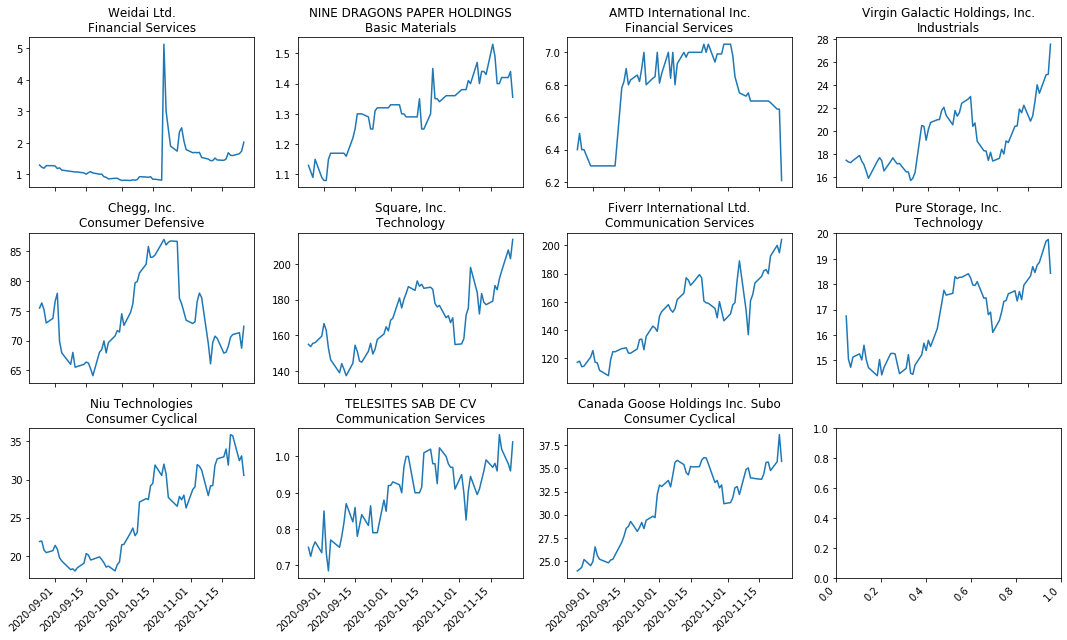

                          Cluster number: 2


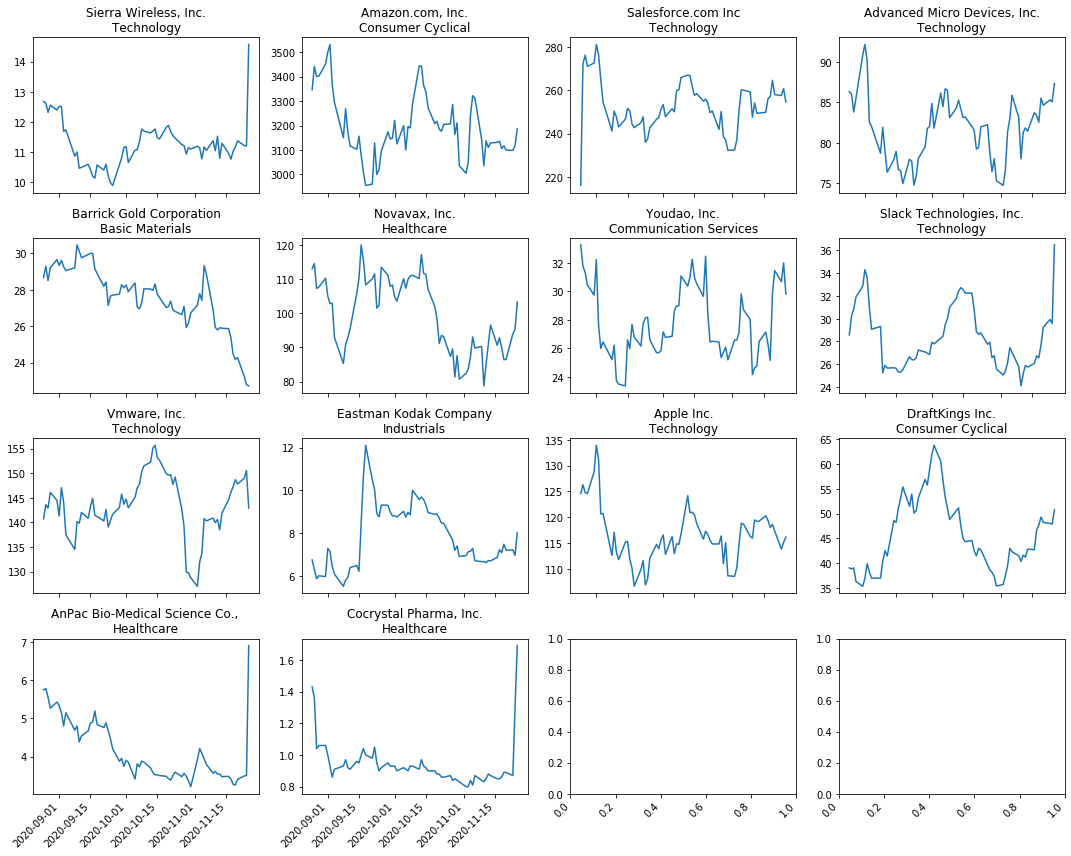

                          Cluster number: 3


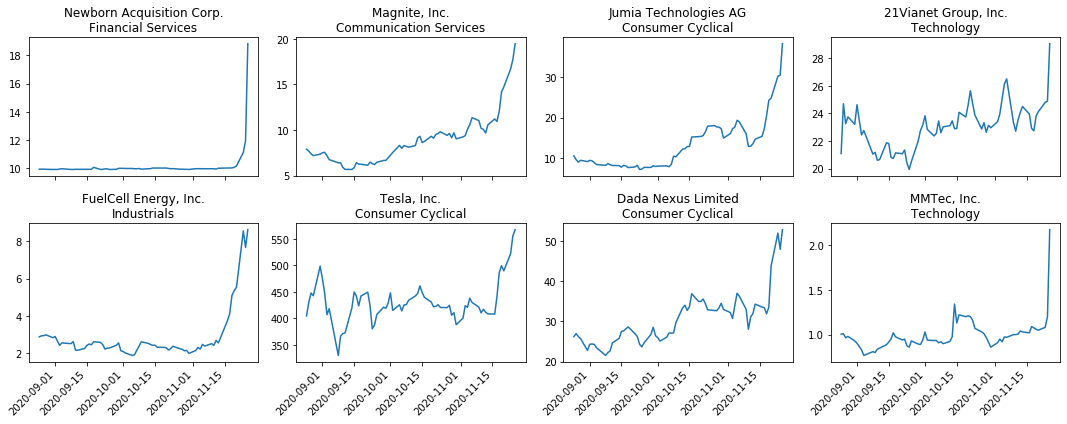

                          Cluster number: 4


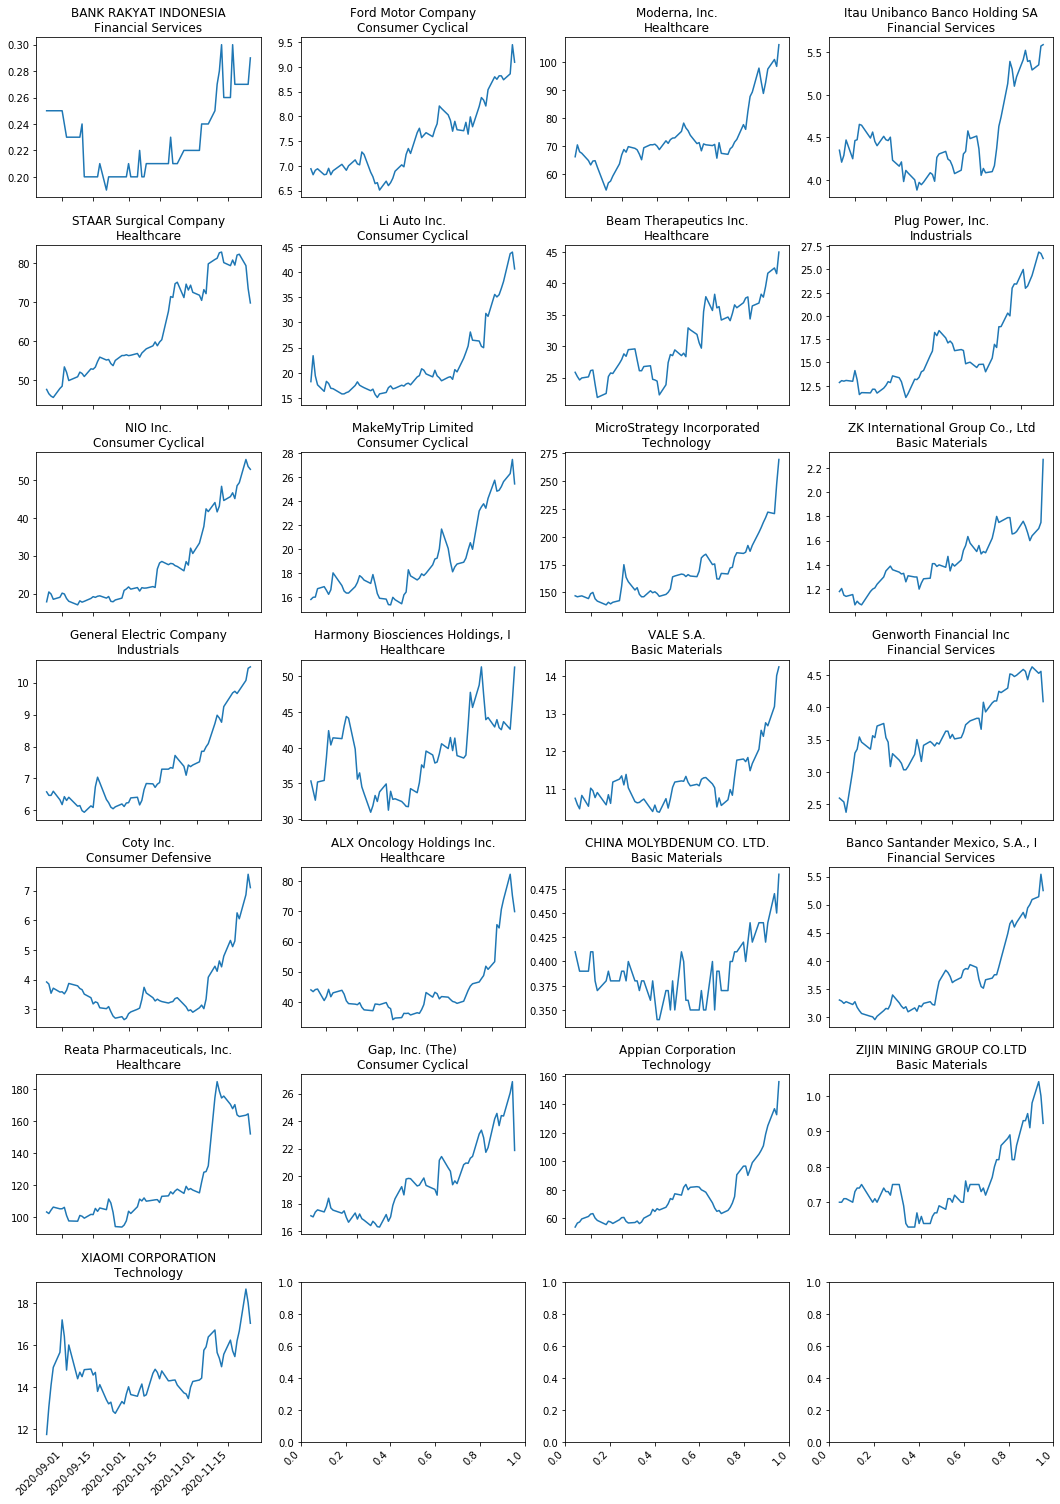

In [29]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# DTW

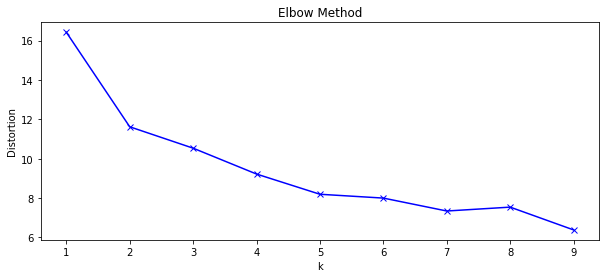

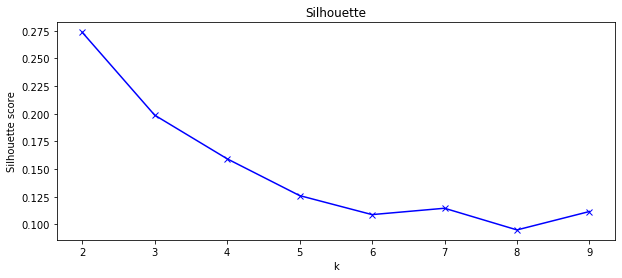

In [20]:
distortions = []
silhouette = []
K = range(1, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    if k > 1:
        silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_))

plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(K[1:], silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette')
plt.show()

In [30]:
n_clusters = 4
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10)
ts_kmeans_dtw.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, metric='dtw', n_clusters=4, n_jobs=6)

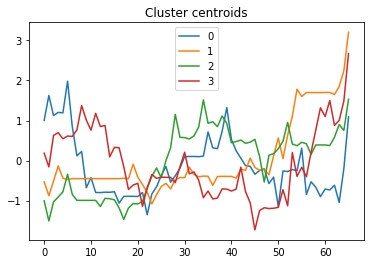

In [31]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [32]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Technology                   5
        Healthcare                   3
        Consumer Cyclical            2
        Basic Materials              1
        Communication Services       1
        Consumer Defensive           1
1       Consumer Cyclical            8
        Healthcare                   4
        Basic Materials              3
        Financial Services           3
        Industrials                  3
        Technology                   3
        Communication Services       1
        Consumer Defensive           1
2       Consumer Cyclical            4
        Financial Services           3
        Technology                   3
        Communication Services       2
        Industrials                  2
        Basic Materials              1
        Healthcare                   1
3       Consumer Cyclical            4
        Financial Services           3
        Technology                   2
        Basic Materials              1
        Consumer Defensive           1
        Energy                       1
        Healthcare                   1
        Industrials                  1
        Real Estate                  1

                          Cluster number: 0


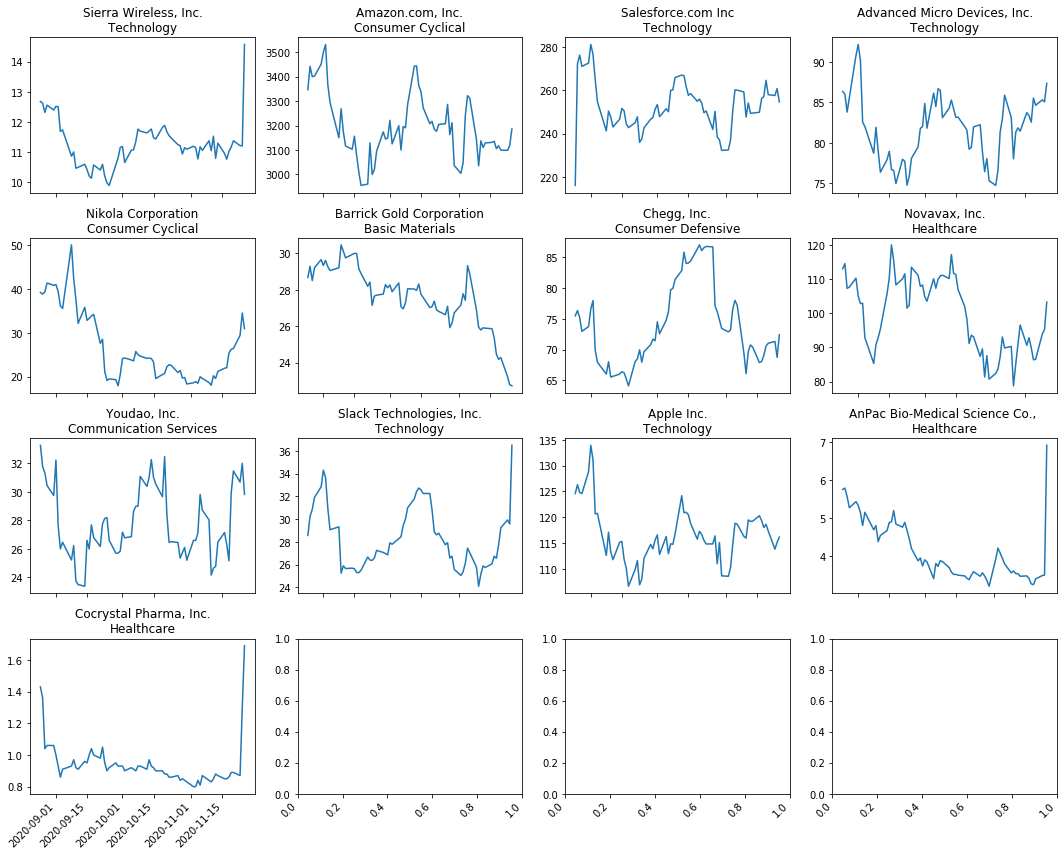

                          Cluster number: 1


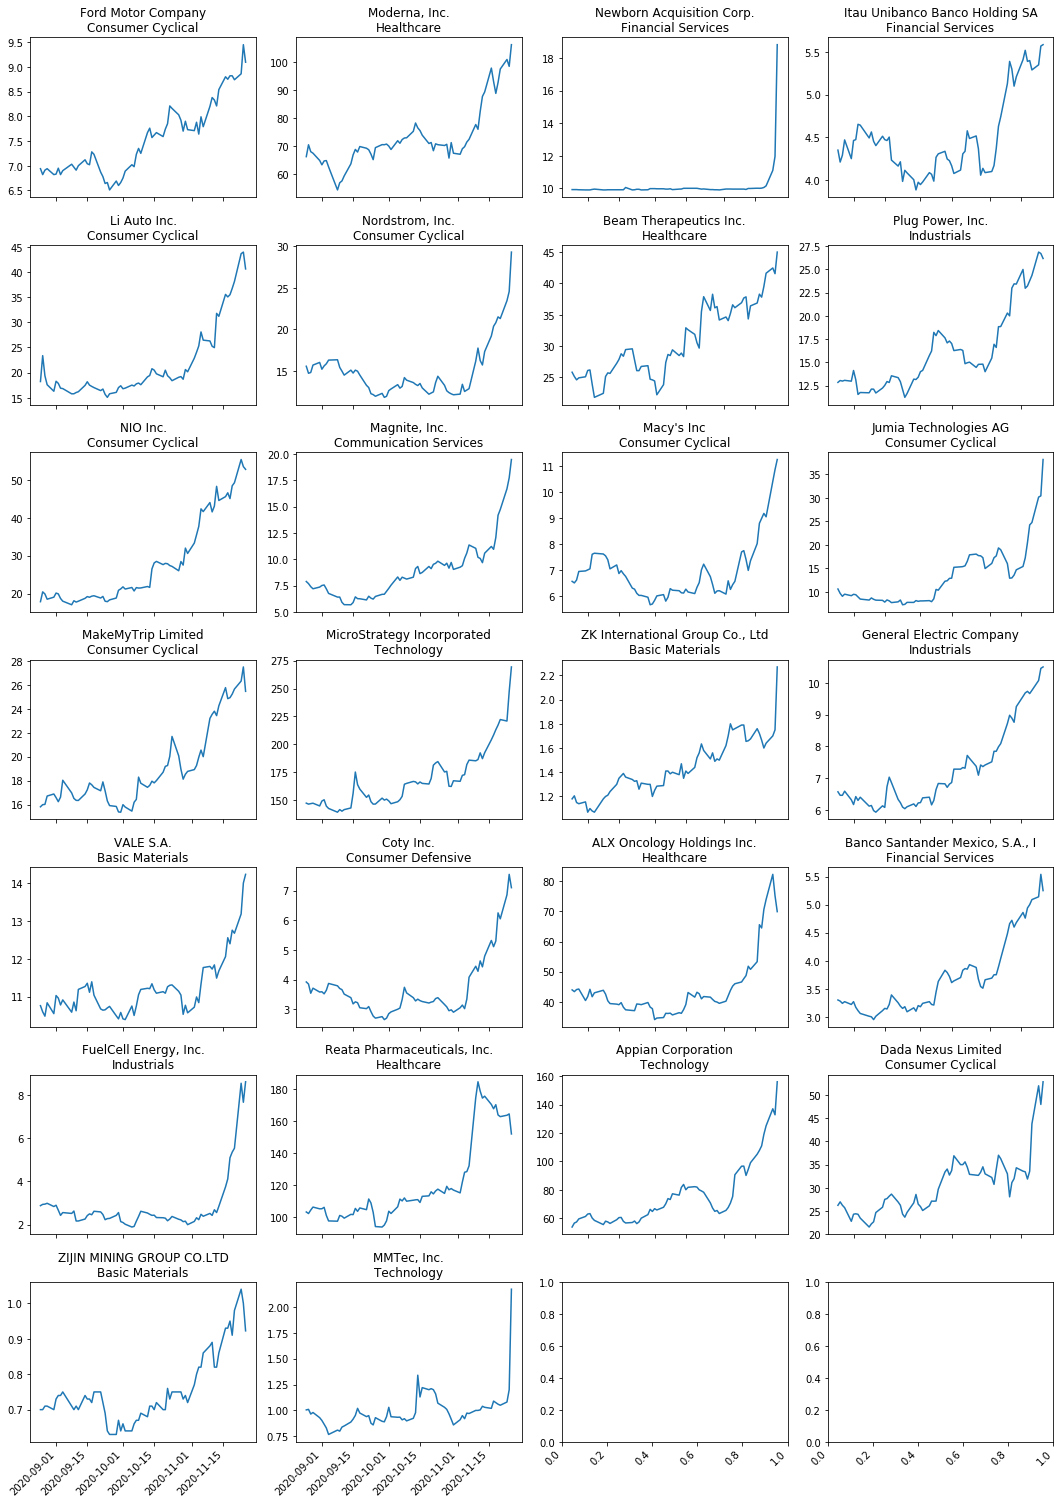

                          Cluster number: 2


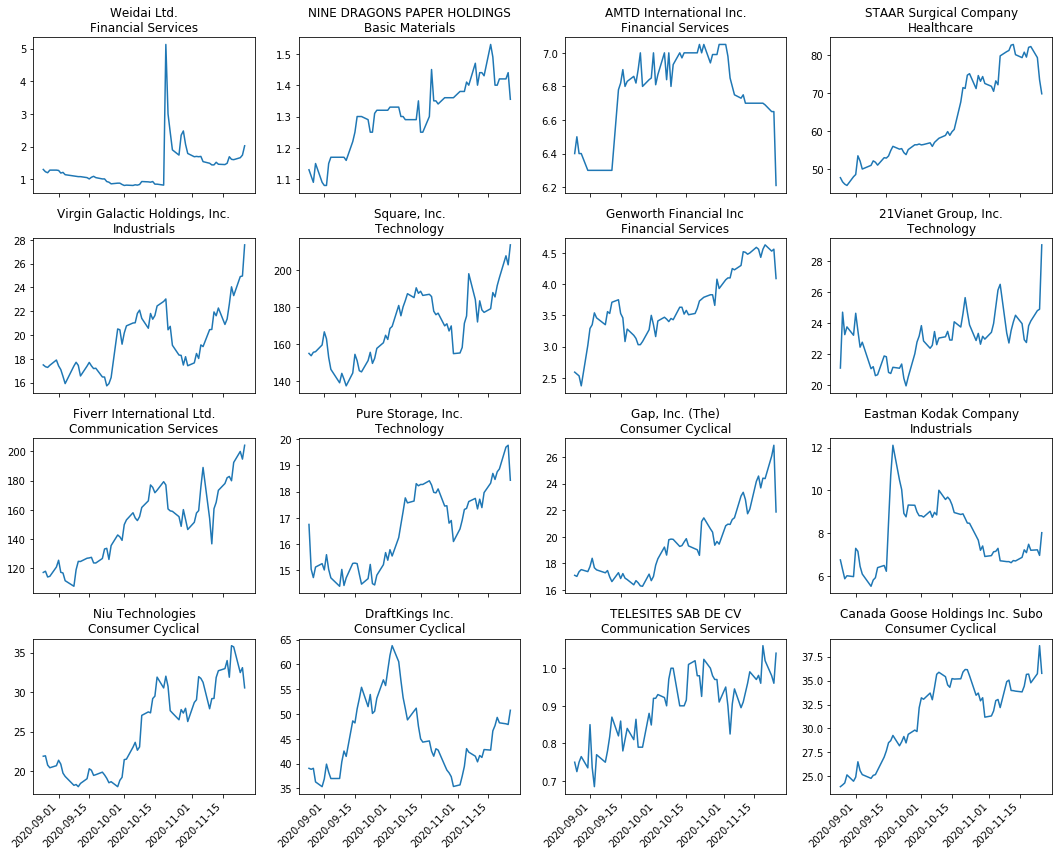

                          Cluster number: 3


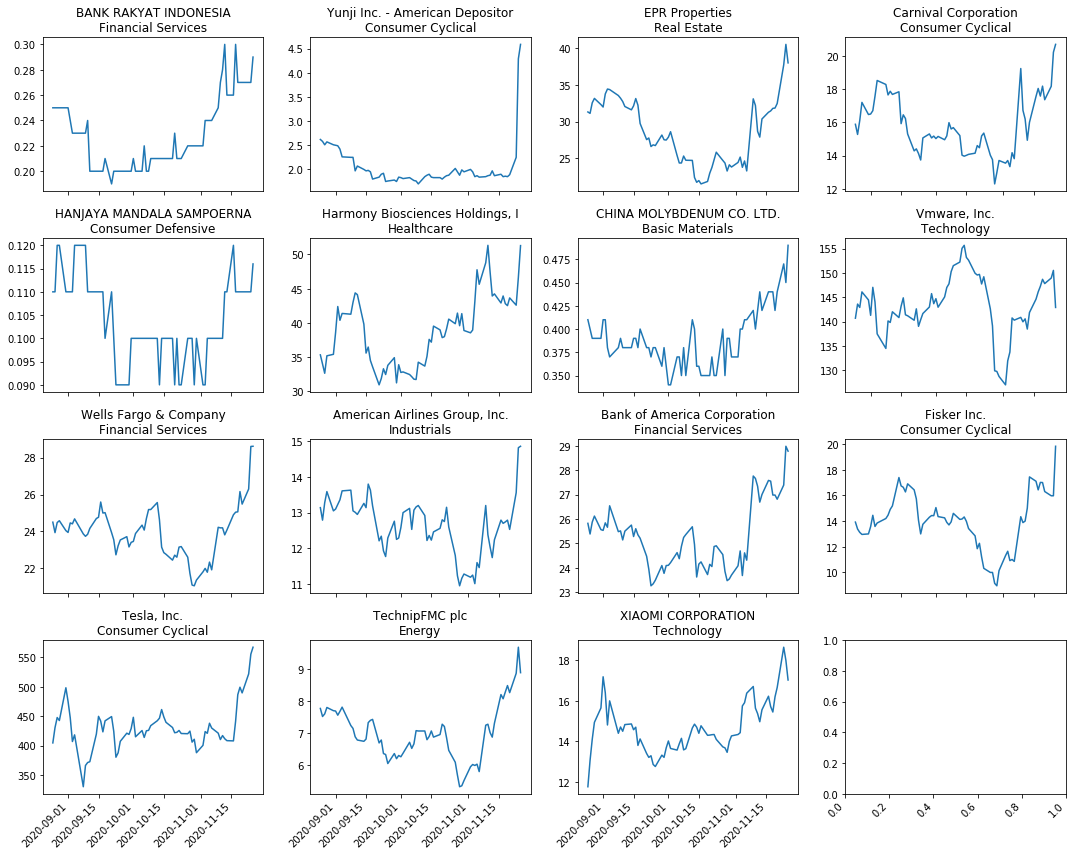

In [33]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])